In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
# import wrds
from tqdm import tqdm 
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
# Connect to WRDS using your WRDS username
# db = wrds.Connection(wrds_username="wl2834")


## Signal Based

In [258]:
technicals = pd.read_csv('technical_data_cleaned_0321.csv')
df = technicals[['ticker', 'date', 'adjfactor', 'open', 'high', 'low', 'volume',
       'adj_prc', 'vwap', 'return', 'SMA_20', 'EMA_12', 'RSI_14', 'EMA_26',
       'MACD', 'MACD_signal', 'MACD_hist', 'BB_Middle', 'BB_Upper', 'BB_Lower',
       'GKDailyVar', 'GKVol', 'GKVol_21', 'GKVol_252', 'RSDailyVar', 'RSVol',
       'RSVol_21', 'RSVol_252']].copy()
df = df.rename(columns = {'adj_prc':'close'})

# 年化参数
TRADING_DAYS = 252

# 计算 next day return
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['ticker', 'date'])
df['next_return'] = df.groupby('ticker')['close'].shift(-1) / df['close'] - 1
technical_df = df.copy()


#  RSI_14  GKVol volume_to_MA20 sentiment vol5_vol20 MACD_signal
technical_df['volume'] *= technical_df['adjfactor']
technical_df = technical_df.sort_values(by=['ticker', 'date'])

# Create relative volume and volume percent change features
technical_df['volume_MA20'] = technical_df.groupby('ticker')['volume'].transform(lambda x: x.rolling(20).mean())
technical_df['volume_to_MA20'] = technical_df['volume'] / technical_df['volume_MA20'] - 1

technical_df['volume_pct_change'] = technical_df.groupby('ticker')['volume'].transform(lambda x: x.pct_change())
technical_df['vol_5'] = technical_df.groupby('ticker')['return'].transform(lambda x: x.rolling(20).std())
technical_df['vol_20'] = technical_df.groupby('ticker')['return'].transform(lambda x: x.rolling(5).std())
technical_df['vol5_vol20'] = technical_df['vol_5']/technical_df['vol_20']

In [5]:
technical_df['ticker'].unique()

array(['AAPL', 'ABBV', 'ADBE', 'AMT', 'AMZN', 'AVGO', 'BA', 'BAC',
       'CMCSA', 'COP', 'COST', 'CVX', 'DIS', 'DUK', 'GOOGL', 'GS', 'HD',
       'HON', 'JNJ', 'JPM', 'KO', 'MCD', 'META', 'MRK', 'MS', 'MSFT',
       'NEE', 'NKE', 'NVDA', 'PEP', 'PFE', 'PG', 'PLD', 'SHW', 'SO',
       'TSLA', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM'], dtype=object)

['factors_china',
 'factors_daily',
 'factors_monthly',
 'fivefactors_daily',
 'fivefactors_monthly',
 'industry12',
 'industry48',
 'liq_ps',
 'liq_sadka',
 'portfolios',
 'portfolios25',
 'portfolios_d']

Loading library list...
Done


,date,mktrf,smb,hml,umd,rmw,cma,rf
0,2017-01-03,0.0083,-0.0011,0.0006,-0.0061,-0.0021,0.0026,0.00002
1,2017-01-04,0.0079,0.0097,-0.0016,-0.0037,-0.0047,-0.0004,0.00002
2,2017-01-05,-0.0021,-0.0102,-0.0079,-0.006,-0.0021,-0.0008,0.00002
3,2017-01-06,0.0029,-0.0074,-0.0031,-0.0018,-0.0035,-0.003,0.00002
4,2017-01-09,-0.0037,-0.0034,-0.0103,-0.0037,0.0014,-0.0052,0.00002
...,...,...,...,...,...,...,...,...
2007,2024-12-24,0.0111,-0.0012,-0.0005,0.0067,-0.0013,-0.0037,0.00017
2008,2024-12-26,0.0002,0.0109,-0.0019,0.0001,-0.0044,0.0035,0.00017
2009,2024-12-27,-0.0117,-0.0044,0.0056,-0.0088,0.0041,0.0003,0.00017
2010,2024-12-30,-0.0109,0.0024,0.0074,0.0006,0.0055,0.0014,0.00017


In [9]:

import os

folder_path = 'sentiments_from_sum_masked'


all_dfs = []


for filename in os.listdir(folder_path):
    if filename.endswith('.parquet'):
        full_path = os.path.join(folder_path, filename)
        df = pd.read_parquet(full_path)
        df['ticker'] = filename.split('_')[0]
        all_dfs.append(df)

# 合并成一个大表
sentiment_df = pd.concat(all_dfs, ignore_index=True)

sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df


,date,sentiment,confidence,summary,ticker
0,2018-01-01,Neutral,1.000000,,COP
1,2018-01-02,Positive,0.468809,**Latin America Markets Rally**\n\nLatin Ameri...,COP
2,2018-01-03,Positive,0.899161,**Latin American Markets Rally Amid Slowing US...,COP
3,2018-01-04,Neutral,0.780704,Energy sector faces disruptions due to gas inf...,COP
4,2018-01-05,Neutral,0.713800,"Energy stocks have been rising, but their perf...",COP
...,...,...,...,...,...
81307,2025-01-28,Negative,0.535059,Consumer Staples: Industry-Wide Implications\n...,WMT
81308,2025-01-29,Negative,0.563910,**Industry Update: Consumer Staples**\n\nThe N...,WMT
81309,2025-01-30,Negative,0.555200,**Consumer Staples Sector Update**\n\nThe UK s...,WMT
81310,2025-01-31,Neutral,0.616393,Industry: Consumer Staples\n\n**Key Developmen...,WMT


In [11]:
technical_df[['RSI_14', 'GKVol', 'volume_to_MA20', 'vol5_vol20', 'MACD_signal']]

,RSI_14,GKVol,volume_to_MA20,vol5_vol20,MACD_signal
0,NaN,0.009423,NaN,NaN,0.000000
1,NaN,0.004537,NaN,NaN,-0.000519
2,NaN,0.005239,NaN,NaN,0.001020
3,NaN,0.008243,NaN,NaN,0.008949
4,NaN,0.007003,NaN,NaN,0.024756
...,...,...,...,...,...
78463,13.039400,0.009873,-0.547929,1.073128,-2.797915
78464,9.560976,0.007236,-0.432510,1.704678,-2.897137
78465,10.828729,0.014650,-0.299640,4.834339,-2.959957
78466,10.769231,0.006246,-0.353388,2.136631,-3.001409


In [536]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant

TRADING_DAYS = 252

# RSI_14 GKVol volume_to_MA20 sentiment vol5_vol20 MACD_signal

# ------------------ 1. 构建多因子 alpha score ------------------
def build_alpha_score(df):
    df = df.copy()
    features = ['RSI_14', 'GKVol', 'volume_to_MA20', 'vol5_vol20', 'MACD_signal']

    for col in features:
        df[col + '_z'] = df.groupby('date')[col].transform(lambda x: (x - x.mean()) / x.std())
    df['alpha_score'] = (
        +df['volume_to_MA20_z'] + df['MACD_signal_z'] #-df['RSI_14_z']  #- df['GKVol_z'] + df['vol5_vol20_z'] 
    )

    df['rank'] = df.groupby('date')['alpha_score'].transform(
        lambda x: pd.qcut(x.rank(method='first'), q=5, labels=False, duplicates='drop')
    )

    df['long_signal'] = (df['rank'] >= 4).astype(int)
    df['short_signal'] = (df['rank'] <= 0).astype(int)

    return df


# ------------------ 2. 回测多空组合 ------------------
def backtest_longshort(df, cost_rate=0.0005):
    """
    df 需要包含 ['date','ticker','next_return','long_signal','short_signal']
    cost_rate: 单边交易成本率，10bps=0.001
    返回 pd.Series：按照日期索引的净收益序列
    """
    df = df.copy().dropna(subset=['next_return'])
    prev_w = None
    dates, net_rets = [], []

    for date, grp in df.groupby('date'):
        grp = grp.set_index('ticker')
        n_long  = grp['long_signal'].sum()
        n_short = grp['short_signal'].sum()
        w_long  = grp['long_signal'] / n_long if n_long > 0 else grp['long_signal'] * 0
        w_short = grp['short_signal'] / n_short if n_short > 0 else grp['short_signal'] * 0
        w_net   = w_long + w_short
        gross_ret = (grp['next_return'] * w_long).sum() + (grp['next_return'] * w_short).sum()

        # w_long  = grp['long_signal'] / n_long if n_long > 0 else grp['long_signal'] * 0
        # w_short = grp['short_signal'] / n_short if n_short > 0 else grp['short_signal'] * 0
        # w_net   = w_long*0.7 + w_short*0.3

        # gross_ret = (grp['next_return'] * w_long*0.7).sum() + (grp['next_return'] * w_short*0.3).sum()
#short只是underweight，不是真的short
        
        if prev_w is None:
            turnover = w_net.abs().sum()
        else:
            all_idx    = prev_w.index.union(w_net.index)
            w_prev     = prev_w.reindex(all_idx, fill_value=0)
            w_current  = w_net.reindex(all_idx, fill_value=0)
            turnover   = (w_current - w_prev).abs().sum()
            
            # # if prev_w is not None and date == '2018-01-11':
            # tickers = df.loc[prev_w[prev_w!=0].index, 'ticker']
            # print(tickers)
            # print("w_prev:", prev_w[prev_w!=0])
            # tickers = df.loc[w_net[w_net!=0].index, 'ticker']
            # print(tickers)
            # print("w_curr:", w_net[w_net!=0])
            # print("turnover:", turnover)
            
            

        cost = turnover * cost_rate
        
        net_ret = (gross_ret - cost)/2
        
        dates.append(date)
        net_rets.append(net_ret)
        prev_w = w_net

    return pd.Series(net_rets, index=pd.to_datetime(dates)).sort_index()


# def backtest_longshort(df):
#     df = df.copy().dropna(subset=['next_return'])

#     long_ret = df.groupby('date').apply(
#         lambda x: (x['next_return'] * x['long_signal']).sum() / x['long_signal'].sum() if x['long_signal'].sum() > 0 else 0
#     )
#     short_ret = df.groupby('date').apply(
#         lambda x: (x['next_return'] * x['short_signal']).sum() / x['short_signal'].sum() if x['short_signal'].sum() > 0 else 0
#     )

#     strategy_ret = long_ret - short_ret
#     return strategy_ret



def summarize_performance(ret_series):
    cumulative = (1 + ret_series.fillna(0)).cumprod()
    total_days = (ret_series.index[-1] - ret_series.index[0]).days
    years = total_days / 365
    cagr = cumulative.iloc[-1]**(1/years) - 1
    vol = ret_series.std() * np.sqrt(TRADING_DAYS)
    sharpe = ret_series.mean() / ret_series.std() * np.sqrt(TRADING_DAYS)
    downside = ret_series[ret_series < 0].std() * np.sqrt(TRADING_DAYS)
    sortino = ret_series.mean() / downside * np.sqrt(TRADING_DAYS) if downside > 0 else np.nan
    running_max = cumulative.cummax()
    drawdown = (cumulative - running_max) / running_max
    max_dd = drawdown.min()
    
    perf = pd.DataFrame({
        'Annualized Return': [cagr],
        'Volatility': [vol],
        'Sharpe Ratio': [sharpe],
        'Sortino Ratio': [sortino],
        'Max Drawdown': [max_dd]
    })
    return perf

def run_equal_weight_benchmark(df):
    benchmark_ret = df.groupby('date')['next_return'].mean()
    cumulative = (1 + benchmark_ret.fillna(0)).cumprod()

    cumulative.plot(title='Equal-weight Buy & Hold Benchmark', figsize=(10,4))
    plt.grid(True)
    plt.show()
    print(summarize_performance(benchmark_ret))
    
    return benchmark_ret

# ------------------ 6. Sentiment Signal Strategy ------------------
def run_sentiment_backtest(df, sentiment_df):
    merged = pd.merge(df, sentiment_df, left_on=['date', 'ticker'], right_on=['date', 'ticker'], how='left')
    merged['sentiment_long'] = (merged['sentiment'] == 'Positive').astype(int)
    merged['sentiment_short'] = (merged['sentiment'] == 'Negative').astype(int)

    long_ret = merged.groupby('date').apply(
        lambda x: (x['next_return'] * x['sentiment_long']).sum() / x['sentiment_long'].sum() if x['sentiment_long'].sum() > 0 else 0
    )
    short_ret = merged.groupby('date').apply(
        lambda x: (x['next_return'] * x['sentiment_short']).sum() / x['sentiment_short'].sum() if x['sentiment_short'].sum() > 0 else 0
    )
    strategy_ret = long_ret - short_ret
    cumulative = (1 + strategy_ret.fillna(0)).cumprod()

    cumulative.plot(title='Sentiment Signal Strategy', figsize=(10,4))
    plt.grid(True)
    plt.show()
    
    return strategy_ret



# ------------------ 7. Combined Alpha + Sentiment Strategy ------------------
def run_combined_sentiment_tech(df, sentiment_df, sentiment_weight=1.0,direction = False):
    df = build_alpha_score(df)
    merged = pd.merge(df, sentiment_df, left_on=['date', 'ticker'], right_on=['date', 'ticker'], how='left')

    sentiment_map = {'Positive': 1, 'Negative': -1, 'Neutral': 0}
    # merged['sentiment_signal'] = merged['sentiment'].map(sentiment_map).fillna(0)

    merged['sentiment_signal'] = merged['sentiment'].map(sentiment_map) * merged['confidence']
    merged = merged.sort_values(['ticker','date'])

    # merged['alpha_smooth_3d'] = (
    #       4 * merged['alpha_score']
    #     + 2 * merged.groupby('ticker')['alpha_score'].shift(1)
    #     + 1 * merged.groupby('ticker')['alpha_score'].shift(2)
        
        
    # ).fillna(0)/7
    # merged['alpha_score'] = merged['alpha_smooth_3d']
    # 权重：
    # merged['sent_smooth_3d'] = (
    #       2 * merged['sentiment_signal']
    #     + 2 * merged.groupby('ticker')['sentiment_signal'].shift(1)
    #     + 2 * merged.groupby('ticker')['sentiment_signal'].shift(2)
        
        
    # ).fillna(0)/6
    
    # 后面就用 sent_smooth_3d 替代原来的 merged['sentiment_signal']
    # merged['sentiment_signal'] = merged['sent_smooth_3d']
    
    merged['sentiment_signal'] = merged.groupby('date')['sentiment_signal'].transform(lambda x: (x - x.mean()) / x.std())
    
    merged['alpha_score'] = merged.groupby('date')['alpha_score'].transform(lambda x: (x - x.mean()) / x.std())

    if direction:
        merged['direction'] = (merged['alpha_score'] * merged['sentiment_signal'])>0 #同方向才long or short
    else:
        merged['direction'] = 1
    merged = merged[merged['direction'] == 1]
    merged['combined_score'] = (1-sentiment_weight)*merged['alpha_score'] + sentiment_weight * merged['sentiment_signal']

    merged['rank'] = merged.groupby('date')['combined_score'].transform(
        lambda x: pd.qcut(x.rank(method='first'), q=5, labels=False, duplicates='drop')
    )
    merged['long_signal'] = (merged['rank'] >= 4).astype(int)
    merged['short_signal'] = (merged['rank'] <= 0).astype(int)

    ret_series = backtest_longshort(merged)
    cumulative = (1 + ret_series.fillna(0)).cumprod()
    

    cumulative.plot(title=f'Combined Technical + Sentiment Strategy, Sentiment Weight ={sentiment_weight} ', figsize=(10,4))
    plt.grid(True)
    plt.show()
    print(summarize_performance(ret_series))

    return ret_series

# ------------------ 8. 主函数 ------------------
def run_pipeline(df, ff_factors):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    ff_factors['date'] = pd.to_datetime(ff_factors['date'])

    print("Step 1: 构建多因子 Alpha 信号")
    df = build_alpha_score(df)

    print("Step 2: 回测 Long-Short 策略")
    ret_series = backtest_longshort(df)
    cumret = (1 + ret_series).cumprod()
    cumret.plot(title="Alpha Strategy Cumulative Return", figsize=(10, 4))
    plt.grid(True)
    plt.show()

    print("Step 3: 与 FF4 回归")
    regress_on_ff(ret_series, ff_factors)

    print("Step 4: 构造单因子组合 + 回归")
    for signal in ['MACD_hist', 'RSI_14', 'GKVol_21', 'BB_Lower']:
        print(f"\n▶ Characteristic Portfolio based on: {signal}")
        f_ret = construct_characteristic_portfolio(df, signal)
        regress_on_ff(f_ret, ff_factors)

    print("Step 5: IC & Rank IC")
    calc_ic(df, 'alpha_score')


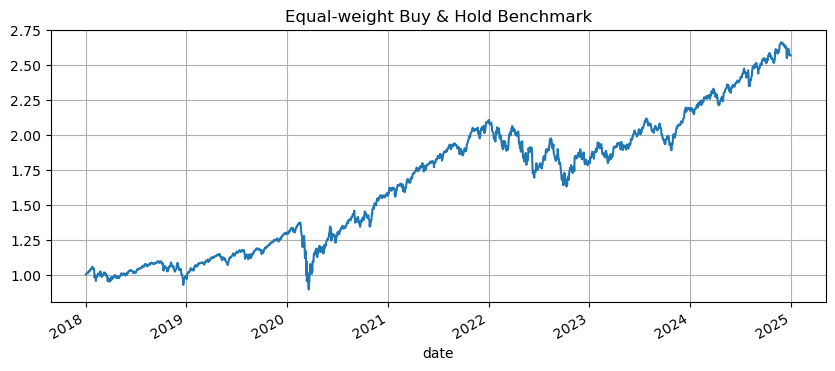

   Annualized Return  Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown
0           0.144452    0.190218      0.806725        0.05991     -0.348103


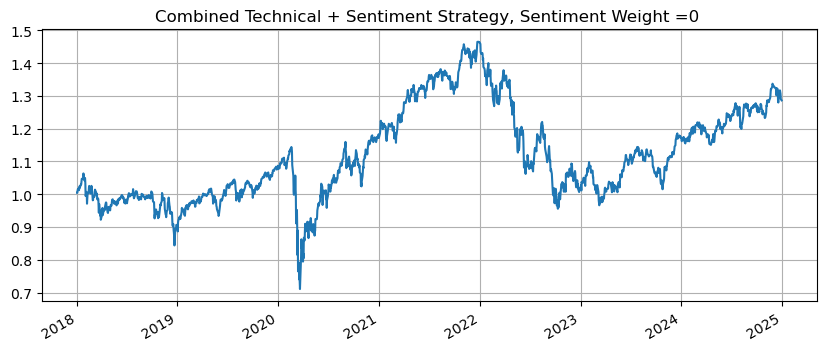

   Annualized Return  Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown
0           0.036637    0.200991      0.280607       0.021411     -0.378594


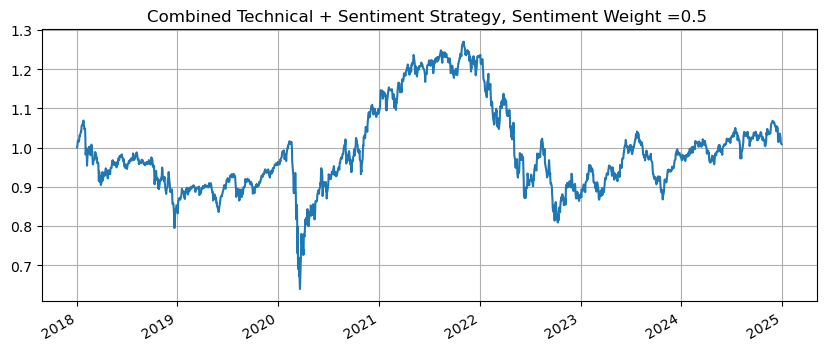

   Annualized Return  Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown
0           0.001255    0.201408      0.107488       0.008287     -0.402017


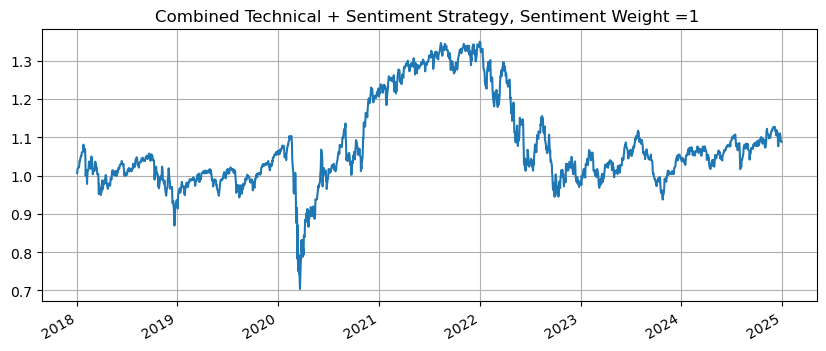

   Annualized Return  Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown
0            0.01216    0.201541      0.161431       0.012384     -0.362471


2018-01-02    0.006393
2018-01-03    0.003051
2018-01-04    0.008272
2018-01-05    0.001692
2018-01-08    0.001735
                ...   
2024-12-23    0.009485
2024-12-24    0.000318
2024-12-26   -0.009674
2024-12-27   -0.009224
2024-12-30   -0.001022
Length: 1760, dtype: float64

In [540]:
# 情绪单独策略
# run_sentiment_backtest(technical_df, sentiment_df)

# test_ticker = ['TSLA', 'NVDA', 'BA', 'META', 'AVGO', 'COP', 'ADBE', 'AMZN', 'WFC', 'NKE']

test_ticker = ['AAPL', 'ABBV', 'ADBE', 'AMT', 'AMZN', 'AVGO', 'BA', 'BAC',
       'CMCSA', 'COP', 'COST', 'CVX', 'DIS', 'DUK', 'GOOGL', 'GS', 'HD',
       'HON', 'JNJ', 'JPM', 'KO', 'MCD', 'META', 'MRK', 'MS', 'MSFT',
       'NEE', 'NKE', 'NVDA', 'PEP', 'PFE', 'PG', 'PLD', 'SHW', 'SO',
       'TSLA', 'UNH', 'UNP', 'VZ', 'WFC', 'WMT', 'XOM']
technical_df_cut = technical_df[technical_df['date']>='2018-01-01']
test_technical = technical_df_cut[technical_df_cut['ticker'].isin(test_ticker)]
test_sentiment = sentiment_df[sentiment_df['ticker'].isin(test_ticker)]
# 综合策略（情绪+技术）
run_equal_weight_benchmark(test_technical)
run_combined_sentiment_tech(test_technical, test_sentiment, sentiment_weight=0)
# run_combined_sentiment_tech(test_technical, test_sentiment, sentiment_weight=0.5,direction = True)
run_combined_sentiment_tech(test_technical, test_sentiment, sentiment_weight=0.5)
run_combined_sentiment_tech(test_technical, test_sentiment, sentiment_weight=1)

,trading_day,mode_of_sentiment,num_articles,ratio_positive,ratio_negative,ratio_neutral,avg_sentiment_positive,avg_sentiment_negative,avg_sentiment_neutral,weighted_avg_sentiment,mode_of_sentiment_score,mode_of_avg_sentiment_score,sentiment_combined,sentiment_score_combined,ticker
0,2018-01-01,Neutral,1,0.000000,0.000000,1.000000,NaN,NaN,1.000000,0.000000,Neutral,Neutral,Neutral,1.000000,BA
1,2018-01-02,Neutral,7,0.285714,0.000000,0.714286,0.000713,NaN,0.000178,0.000204,Positive,Positive,Positive,0.000337,BA
2,2018-01-03,Neutral,4,0.250000,0.000000,0.750000,0.000554,NaN,0.000319,0.000139,Neutral,Positive,Positive,0.000532,BA
3,2018-01-04,Positive,4,0.750000,0.000000,0.250000,0.000652,NaN,0.000304,0.000489,Positive,Positive,Positive,0.000435,BA
4,2018-01-05,Positive,3,0.666667,0.000000,0.333333,0.000296,NaN,0.000363,0.000197,Positive,Neutral,Neutral,0.000363,BA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1843,2025-01-28,Neutral,36,0.444444,0.055556,0.500000,0.000443,0.000188,0.000212,0.000186,Positive,Positive,Neutral,0.000255,BA
1844,2025-01-29,Positive,15,0.733333,0.000000,0.266667,0.000440,NaN,0.000302,0.000323,Positive,Positive,Positive,0.000295,BA
1845,2025-01-30,Neutral,15,0.466667,0.000000,0.533333,0.000503,NaN,0.000229,0.000235,Positive,Positive,Neutral,0.000272,BA
1846,2025-01-31,Neutral,9,0.333333,0.000000,0.666667,0.000237,NaN,0.000203,0.000079,Neutral,Positive,Neutral,0.000371,BA


In [313]:
import yfinance as yf


tickers_obj = yf.Ticker('^GSPC')
tickers_obj
try:
    history = tickers_obj.history(start='2017-12-29', end='2025-01-01')['Close']
except Exception as e:
    print(f"❌ Failed to get data for spy: {e}")
 
df_spy = pd.DataFrame(history).dropna().reset_index()
df_spy['Date'] = pd.to_datetime(df_spy['Date']).dt.tz_localize(None)
df_spy['spyret'] = df_spy['Close'].pct_change()
df_spy = df_spy.dropna()
df_spy = df_spy.rename(columns = {'Date':'date'})
df_spy


,date,Close,spyret
1,2018-01-02,2695.810059,0.008303
2,2018-01-03,2713.060059,0.006399
3,2018-01-04,2723.989990,0.004029
4,2018-01-05,2743.149902,0.007034
5,2018-01-08,2747.709961,0.001662
...,...,...,...
1757,2024-12-24,6040.040039,0.011043
1758,2024-12-26,6037.589844,-0.000406
1759,2024-12-27,5970.839844,-0.011056
1760,2024-12-30,5906.939941,-0.010702


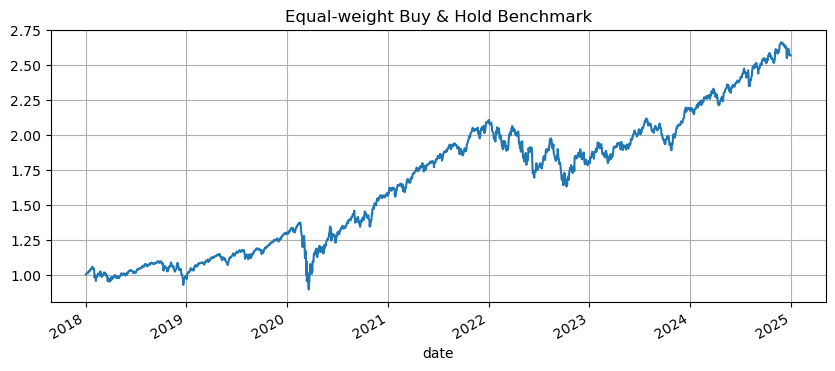

   Annualized Return  Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown
0           0.144452    0.190218      0.806725        0.05991     -0.348103


date
2018-01-02    0.004359
2018-01-03    0.002613
2018-01-04    0.006024
2018-01-05    0.002523
2018-01-08    0.000050
                ...   
2024-12-24    0.000590
2024-12-26   -0.007624
2024-12-27   -0.010178
2024-12-30    0.000231
2024-12-31         NaN
Name: next_return, Length: 1761, dtype: float64

In [315]:
benchmark_ret = run_equal_weight_benchmark(test_technical)
benchmark_ret

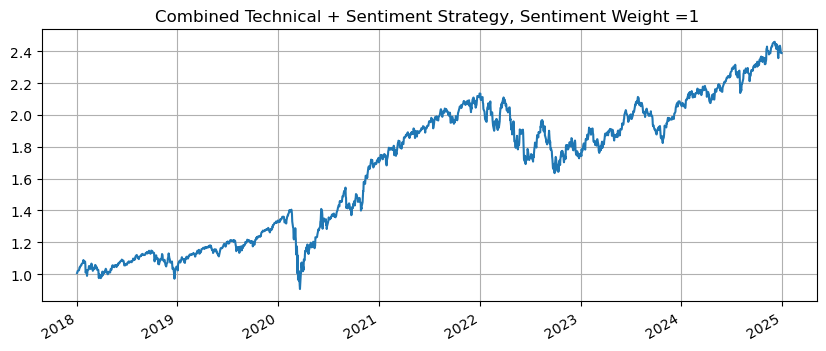

   Annualized Return  Volatility  Sharpe Ratio  Sortino Ratio  Max Drawdown
0           0.132547    0.201494      0.720317       0.054658     -0.354944


2018-01-02    0.006893
2018-01-03    0.003496
2018-01-04    0.008661
2018-01-05    0.002026
2018-01-08    0.002235
                ...   
2024-12-23    0.010041
2024-12-24    0.000818
2024-12-26   -0.009396
2024-12-27   -0.008836
2024-12-30   -0.000745
Length: 1760, dtype: float64

In [523]:
testff = technical_df[technical_df['date']>='2018-01-01']
ret_series = run_combined_sentiment_tech(testff,test_sentiment, sentiment_weight=1)
ret_series

In [525]:
aligned = df_spy.merge(pd.DataFrame(benchmark_ret.shift(1)).rename(columns = {'next_return':'bench'}).reset_index(), on = 'date', how='left')
aligned = aligned.merge(pd.DataFrame(ret_series).reset_index().rename(columns = {'index':'date',0:'strategy'}), on = 'date', how='left')

aligned
# df_spy['ret'][:-1].corr(benchmark_ret[251:-1])

,date,Close,spyret,bench,strategy
0,2018-01-02,2695.810059,0.008303,NaN,0.006893
1,2018-01-03,2713.060059,0.006399,0.004359,0.003496
2,2018-01-04,2723.989990,0.004029,0.002613,0.008661
3,2018-01-05,2743.149902,0.007034,0.006024,0.002026
4,2018-01-08,2747.709961,0.001662,0.002523,0.002235
...,...,...,...,...,...
1756,2024-12-24,6040.040039,0.011043,0.010258,0.000818
1757,2024-12-26,6037.589844,-0.000406,0.000590,-0.009396
1758,2024-12-27,5970.839844,-0.011056,-0.007624,-0.008836
1759,2024-12-30,5906.939941,-0.010702,-0.010178,-0.000745


In [527]:
ff_df

,date,mktrf,smb,hml,umd,rmw,cma,rf
0,2017-01-03,0.0083,-0.0011,0.0006,-0.0061,-0.0021,0.0026,0.00002
1,2017-01-04,0.0079,0.0097,-0.0016,-0.0037,-0.0047,-0.0004,0.00002
2,2017-01-05,-0.0021,-0.0102,-0.0079,-0.006,-0.0021,-0.0008,0.00002
3,2017-01-06,0.0029,-0.0074,-0.0031,-0.0018,-0.0035,-0.003,0.00002
4,2017-01-09,-0.0037,-0.0034,-0.0103,-0.0037,0.0014,-0.0052,0.00002
...,...,...,...,...,...,...,...,...
2007,2024-12-24,0.0111,-0.0012,-0.0005,0.0067,-0.0013,-0.0037,0.00017
2008,2024-12-26,0.0002,0.0109,-0.0019,0.0001,-0.0044,0.0035,0.00017
2009,2024-12-27,-0.0117,-0.0044,0.0056,-0.0088,0.0041,0.0003,0.00017
2010,2024-12-30,-0.0109,0.0024,0.0074,0.0006,0.0055,0.0014,0.00017


In [529]:
aligned[['spyret','bench','strategy']].dropna().corr()

,spyret,bench,strategy
spyret,1.000000,0.976814,-0.163079
bench,0.976814,1.000000,-0.175369
strategy,-0.163079,-0.175369,1.000000


<Figure size 3600x1800 with 0 Axes>

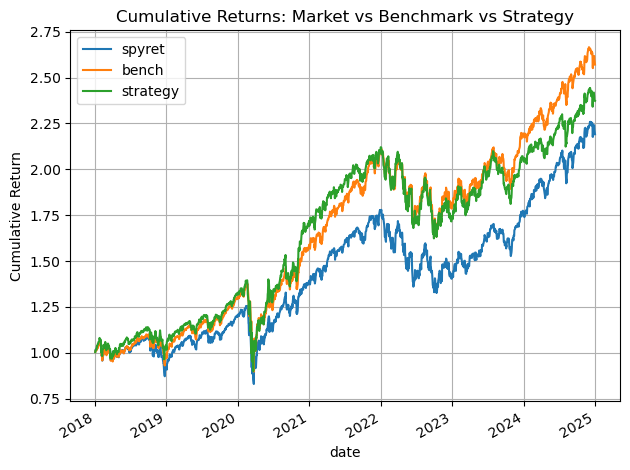

In [532]:
import matplotlib.pyplot as plt

# 设定日期为索引
df = aligned.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# 去掉 NaN，计算累计收益
df = df.dropna(subset=['spyret', 'bench', 'strategy'])
cum_ret = (1 + df[['spyret', 'bench', 'strategy']]).cumprod()

# 绘图
plt.figure(figsize=(36, 18))
cum_ret.plot(title='Cumulative Returns: Market vs Benchmark vs Strategy')
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()


In [534]:
# import pandas as pd
# import statsmodels.api as sm
# import wrds

# # Connect to WRDS using your WRDS username
# db = wrds.Connection(wrds_username="wenxzeng")
# ff_df = db.raw_sql("""
#     SELECT date, mktrf, smb, hml, umd, rmw, cma, rf
#     FROM ff.fivefactors_daily
#     WHERE date >= '2017-01-01'
# """)
# ff_df['date'] = pd.to_datetime(ff_df['date'])



def ff5_return_decomposition(returns_df, factors_df,
                             date_col='date',
                             ret_col='strategy',
                             rf_col='rf',
                             factor_cols=['mktrf','smb','hml','rmw','cma','umd']):
    """
    参数
    ----
    returns_df : pd.DataFrame  
        至少包含 [date_col, ret_col]   
    factors_df : pd.DataFrame  
        至少包含 [date_col] + factor_cols + [rf_col]  
    返回
    ----
    coef      : pd.Series  
        回归系数，包括常数项  
    contrib   : pd.DataFrame  
        每期因子贡献 = coef[f] * factor_return  
        另含常数项贡献和残差项  
    summary   : statsmodels RegressionResults  
        完整回归结果对象
    """
    # 合并数据
    df = (
        returns_df[[date_col, ret_col]]
        .merge(factors_df[[date_col] + factor_cols + [rf_col]],
               on=date_col, suffixes=('','_fac'))
        .dropna()
        .set_index(date_col)
    )
    # 计算超额收益
    y = df[ret_col] - df[rf_col]
    # 因子矩阵
    X = df[factor_cols]
    X = sm.add_constant(X)
    
    X = X.astype(np.float64)
    y = y.astype(np.float64)
    
    # OLS 回归
    model = sm.OLS(y, X).fit()
    coef = model.params
    
    # 因子贡献 = 因子暴露 × 因子值
    contrib = X.multiply(coef, axis=1)
    contrib['residual'] = model.resid
    contrib['total_excess_ret'] = y
    
    return coef, contrib, model

# 用法示例
# ff5_df = …  # 包含 date + mktrf,smb,hml,rmw,cma,umd,rf
# ret_df = your_return_df  # 包含 date + strategy + rf
coef, contrib_df, res = ff5_return_decomposition(
    returns_df=aligned,
    factors_df=ff_df,
    date_col='date',
    ret_col='strategy',
    rf_col='rf',
    factor_cols=['mktrf','smb','hml','rmw','cma','umd']
)

print("因子暴露：\n", coef)
print("\n前 5 行分解贡献：\n", contrib_df.head())
print("\n回归摘要：\n", res.summary())


因子暴露：
 const    0.000577
mktrf   -0.184058
smb      0.171063
hml     -0.122885
rmw      0.052831
cma     -0.025306
umd     -0.055944
dtype: float64

前 5 行分解贡献：
                const     mktrf       smb       hml       rmw       cma  \
date                                                                     
2018-01-02  0.000577 -0.001564  0.000513  0.000270 -0.000264 -0.000078   
2018-01-03  0.000577 -0.001086 -0.000787  0.000221 -0.000370  0.000015   
2018-01-04  0.000577 -0.000773 -0.000376 -0.000295 -0.000011 -0.000078   
2018-01-05  0.000577 -0.001215 -0.000633  0.000320  0.000195  0.000094   
2018-01-08  0.000577 -0.000350 -0.000342 -0.000049 -0.000037 -0.000000   

                 umd  residual  total_excess_ret  
date                                              
2018-01-02  0.000358  0.007022          0.006833  
2018-01-03 -0.000123  0.004988          0.003436  
2018-01-04  0.000112  0.009445          0.008601  
2018-01-05 -0.000336  0.002963          0.001966  
2018-01-08 -0.

In [ ]:
# ------------------ 3. 构建特征组合收益（Top-Bottom） ------------------
# def construct_characteristic_portfolio(df, signal):
#     df = df.copy().dropna(subset=[signal, 'next_return'])
#     df['rank'] = df.groupby('date')[signal].transform(
#         lambda x: pd.qcut(x.rank(method='first'), q=5, labels=False, duplicates='drop')
#     )

#     df['long'] = (df['rank'] >= 4).astype(int)
#     df['short'] = (df['rank'] <= 0).astype(int)

#     long_ret = df.groupby('date').apply(
#         lambda x: (x['next_return'] * x['long']).sum() / x['long'].sum() if x['long'].sum() > 0 else 0
#     )
#     short_ret = df.groupby('date').apply(
#         lambda x: (x['next_return'] * x['short']).sum() / x['short'].sum() if x['short'].sum() > 0 else 0
#     )

#     factor_ret = long_ret - short_ret
#     return factor_ret

# # ------------------ 4. FF 回归分析 ------------------
# def regress_on_ff(factor_ret, ff_df):
#     merged = pd.merge(factor_ret.rename('factor'), ff_df, on='date', how='inner')
#     X = add_constant(merged[['mktrf', 'smb', 'hml', 'umd']]) if 'umd' in ff_df.columns else add_constant(merged[['mktrf', 'smb', 'hml']])
#     y = merged['factor']
#     model = OLS(y, X).fit()
#     print(model.summary())
#     return model

# # ------------------ 5. IC / Rank IC ------------------
# def calc_ic(df, signal, ret_col='next_return'):
#     ic = df.groupby('date').apply(lambda x: x[[signal, ret_col]].corr().iloc[0, 1])
#     rank_ic = df.groupby('date').apply(lambda x: x[[signal, ret_col]].rank().corr().iloc[0, 1])
#     print(f"IC mean: {ic.mean():.4f}, std: {ic.std():.4f}")
#     print(f"Rank IC mean: {rank_ic.mean():.4f}, std: {rank_ic.std():.4f}")
#     return ic, rank_ic